# Практическое задание 3 

# Классификация с использованием BERT  и Transfer learning

## курс "Математические методы анализа текстов"


### ФИО: <впишите>

## Введение


В этом задании вы будете определять категории товара по данным из чеков, предоставленным в соревновании [Data Fusion Context](https://boosters.pro/championship/data_fusion/data).


Для этого задания вам понадобятся следующие библиотеки:
 - [Pytorch](https://pytorch.org/).
 - [Transformers](https://github.com/huggingface/transformers).
 - [Tokenizers](https://github.com/huggingface/tokenizers).

Данные лежат в архиве data.zip, в котором лежит файл `data.csv`, содержащий тексты и соответствующие им категории товаров. Все объекты поделены между train, test, val и unsupervised. Для unsupervised объектов категории товаров недоступны. 

Скачать данные можно здесь: [ссылка на google диск](https://drive.google.com/file/d/1AHs7qJYg2tc8zblGlT0Dpe50e6RW-gAW/view?usp=sharing)

In [110]:
import tests as tests

## Часть 1. Подготовка данных (2 балла)

Классические методы NLP (например, как мы делали в первом и втором домашнем задании) преобразуют тексты в списки индексов следующим образом:
1. "Очистка текста" от плохих символов, приводим (или не приводим) текст к нижнему регистру.
2. Текст делится по пробелам на слова.
3. По полученной коллекции текстов строится словарь вида "слово -> индекс", редкие слова выбрасываются, стопслова иногда тоже
4. Побитый на слова текст превращается в список индексов с помощью этого словаря.

Для трансформеров схема выглядит немного по-другому — используются более продвинутые методы токенизации типа `wordpiece, bpe, sentencepiece`. Основное концептуальное отличие — текст делится не только на слова по пробелам, но и сами слова делятся на "подслова" (читай subwords). Это верно для BPE и wordpiece, а sentencepiece вообще не учитывает пробелы. Более подробно ознакомиться с этими методами токенизации можно в наших лекциях.

В данном задании предлагается использовать wordpiece токенизатор, который использовали в оригинальной статье про BERT. Построить его можно с помощью библиотеки `tokenizers`:
1. Считайте данные с помощью `pandas`
2. Используя метод `tokenizers.BertWordPieceTokenizer.train` и список сырых текстов постройте токенизатор. Используйте нижний регистр (lowercase), чистый текст (clean_text), без акцентов (strip_accents), размера словаря 30000 (vocab_size).
3. Сохраните построенный токенизатор (метод `tokenizer.save_model`) и создайте объект класса `transformers.BertTokenizerFast`, который работает быстрее стандартной реализации, но не позволяет её обучать.

**Важно:** нужно при обучении c помощью параметра `special_tokens` завести индексы для токенов `[PAD], [UNK], [CLS], [SEP], [MASK]`, которые понадобятся нам дальше для обучения и использования модели.

In [2]:
import pandas as pd

data = pd.read_csv('task3_data.csv')

In [3]:
data.head()

,text,label,split
0,Флуконазол капс 150мг №1 Вертекс,-1,unsupervised
1,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",-1,unsupervised
2,"Филе Горизонт (филе птицы), 218 ккал",-1,unsupervised
3,3 Бумага Упак 1/Прочи/В асс,-1,unsupervised
4,4 Бумага Упак 1/Прочи/В асс,-1,unsupervised


In [4]:
data.label.unique()

array([-1, 48,  0, 38, 41, 88, 22, 61, 62, 78, 55, 51, 60, 53, 95, 57, 27,
       25, 47, 54, 24, 75,  4, 59, 94, 58, 40, 46, 87, 20, 83, 33, 39, 56,
       86, 45, 52, 80, 85, 34, 50, 70,  2,  1,  7, 30, 35,  9, 43, 28,  3,
       74, 31, 32, 23, 49, 79, 42, 37, 16, 11, 81, 71, 44, 91, 76, 17, 93,
       26,  8,  6, 73, 92, 21, 84, 12, 77, 63, 72, 65, 13,  5, 68, 14, 15,
       36, 64, 82, 18, 10, 69, 19, 89, 90, 66, 67, 29])

In [5]:
data.split.unique()

array(['unsupervised', 'train', 'val', 'test'], dtype=object)

In [6]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast

class WordpieceTokenizer:

    def __init__(
            self, 
            vocab_path, 
            strip_accents=True, 
            clean_text=True, 
            lowercase=True
    ):
        """
            vocab_path: путь к словарю
            strip_accents: очистка текста от акцентов
            clean_text: просто чистка текста от непонятных символов
            lowercase: приведение текста к нижнему регистру
            
            Подгружает токенизатор с помощью BertTokenizerFast.
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._tokenizer = BertTokenizerFast(
            vocab_path,
            strip_accents=strip_accents,
            clean_text=clean_text,
            do_lower_case=lowercase,
        )

    @classmethod
    def from_corpus(
            cls,
            corpus,
            corpus_save_path,
            tokenizer_save_path,
            tokenizer_name,
            vocab_size=30000,
            min_frequency=2,
            strip_accents=True,
            clean_text=True,
            lowercase=True
    ):
        """
            corpus: список текстов
            corpus_save_path: временный путь для сохранения текстов в текстовом файле
            tokenizer_save_path: путь для сохранения файлов токенизатора
            tokenizer_name: название токенизатора, влияет на названия файлов токенизатора
            vocab_size: размер словаря
            min_frequency: минимальная частота элемента в словаре
            strip_accents: очистка текста от акцентов
            clean_text: просто чистка текста от непонятных символов
            lowercase: приведение текста к нижнему регистру
            
            С помощью списка сырых текстов формирует токенизатор
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        with open(corpus_save_path, 'w', encoding='utf-8') as f:
            for text in corpus:
                f.write(f"{text}\n")

        tokenizer = BertWordPieceTokenizer(
            clean_text=clean_text,
            strip_accents=strip_accents,
            lowercase=lowercase
        )

        tokenizer.train(
            files=[corpus_save_path],
            vocab_size=vocab_size,
            min_frequency=min_frequency,
            special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
        )

        tokenizer.save_model(tokenizer_save_path, tokenizer_name)
        vocab_path = tokenizer_save_path + tokenizer_name + "-vocab.txt"
        return cls(
            vocab_path,
            strip_accents,
            clean_text,
            lowercase
        )


    def __call__(self, text):
        """
            text: str. Сырой текст
            
            returns: list of ints. Список индексов
            
            C помощью метода .encode преобразует текст в индексы.
        """
        return self._tokenizer.encode(text, add_special_tokens=False)

    @property
    def cls_token_id(self):
        """
            returns: индекс CLS токена
        """
        return self._tokenizer.cls_token_id

    @property
    def pad_token_id(self):
        return self._tokenizer.pad_token_id

    @property
    def mask_token_id(self):
        return self._tokenizer.mask_token_id

    @property
    def sep_token_id(self):
        return self._tokenizer.sep_token_id

    @property
    def unk_token_id(self):
        return self._tokenizer.unk_token_id

    @property
    def vocab_size(self):
        """
            returns: размер словаря
        """
        return self._tokenizer.vocab_size

Создайте токенизатор:

In [7]:
tokenizer = WordpieceTokenizer.from_corpus(
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
    corpus=data["text"].tolist(),
    corpus_save_path='text_data.txt',
    tokenizer_save_path='',
    tokenizer_name="BertWordPieceTokenizer",
)

tests.test_tokenizer(tokenizer)




Correct.


Нам доступно довольно большое количество неразмеченных данных, которое можно использовать для предобучения модели. Мы рассмотрим две задачи предобучения:
1. **Masked Language Modeling** — задача из BERT. Выбираем 15% слов, из них 80% заменяем на токен [MASK], 10% меняем на другие случайные слова, 10% оставляем как есть. Эти 15% слов предсказываем моделью. Вспомним пример из оригинальной статьи:
    * Исходный текст: `my dog is hairy`
    * Выбираем случайным образом 15% токенов для задачи. Допустим, выбрали четвертый токен - `hairy`
    * В 80% случаев заменяем токен на `[MASK]`: `my dog is [MASK]`
    * В 10% случаев на другой случайный токен: `my dog is apple`
    * В 10% случаев оставляем неизменным: `my dog is hairy`
    
    
2. **Sentence Order Prediction** — задача из ALBERT. Делим текст на два сегмента, с вероятностью 50% меняет сегменты местами. Предсказываем, в правильном ли порядке находятся сегменты.
    * Текст: `the man went to the store. he bought a gallon of milk`
    * Токенизируем и делим его на два сегмента: `the man went to the store` и `he bought a gallon of milk`
    * C вероятностью 50% меняем их местами: `[CLS] he bought a gallon of milk [SEP] the man went to the store`
    * С вероятностью 50% оставляем на месте: `[CLS] the man went to the store [SEP] he bought a gallon of milk`
    * "Левому" сегменту соответствует нулевой индекс сегмента, "правому" - индекс 1

Большая часть логики предобучения реализуется при подготовке данных.

Реализуйте **PretrainDataset**, который токенизирует поданные сырые тексты и умеет возвращать для текста с конкретным индексом случайный сегмент длины, не большей чем `maxlen`. Логика для задачи **SOP** должна быть реализована в `__getitem__`: выбранный сегмент надо поделить на два равных сегмента, подбросить монетку, и с 50% вероятностью поменять сегменты местами. Нужно также добавить `[CLS]` и `[SEP]` токены.

**hint:** чтобы существенно ускорить обучение (не потеряв при этом в качестве), после токенизации отсортируйте датасет по длине текстов.
**hint:** токенизация датасета для предобучения занимает существенное время (5 минут), поэтому во время отладки стоит сделать её один раз и сохранить результат на диск

In [8]:
from tqdm import tqdm
import numpy as np
import random

import torch
from torch.utils.data import Dataset


class PretrainDataset(Dataset):
    
    def __init__(
            self, 
            corpus, 
            tokenizer, 
            minlen,
            maxlen,
            permute_prob=0.5, 
            verbose=False, 
            presort=False
    ):
        """
            corpus: list of strings. Список сырых текстов
            tokenizer: токенизатор
            minlen: минимально допустимая длина текста
            permute_prob: вероятность, с которой два сегмента меняются местами (происходит swap)
            maxlen: максимальная длина текста
            verbose: вывод прогресса токенизации текстов с помощью tqdm
            presort: отсортировать датасет по длинам токенизированных текстов (т.е. ds[0] выдает самый короткий текст)
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._tokenizer = tokenizer
        self._minlen = minlen
        self._maxlen = maxlen
        self.permute_prob = permute_prob
        self.verbose = verbose
        self.presort = presort

        self._corpus = []
        for text in tqdm(corpus, disable = not verbose):
            tokens = tokenizer(text)
            if minlen <= len(tokens):
                self._corpus.append(tokens)
        if presort:
            self._corpus.sort(key=len)
        
        
    def __len__(self):
        return len(self._corpus)
    
    @property
    def tokenizer(self):
        """
            returns: tokenizer. Нужно для тестов
        """
        return self._tokenizer
    
    def set_maxlen(self, maxlen):
        """
            maxlen: максимальная длина текста
            
            поставить новое максимальное значение длины
        """
        self._maxlen = maxlen
        
    def __getitem__(self, idx):
        """
            returns: 
                input_ids - тензор с индексами, 
                token_type_ids - тензор с сегментными айдишниками (0 у левого сегмента, 1 у правого),
                permuted - был ли swap сегментов
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        tokens = self._corpus[idx][:self._maxlen]
        mid = len(tokens) // 2
        left, right = tokens[:mid], tokens[mid:]

        permuted = np.random.uniform() > self.permute_prob
        if permuted:
            input_ids = [self._tokenizer.cls_token_id] + right + [self._tokenizer.sep_token_id] + left
            token_type_ids = [1]*(len(right)+2) + [0]*len(left)
        else:
            input_ids = [self._tokenizer.cls_token_id] + left + [self._tokenizer.sep_token_id] + right
            token_type_ids = [0]*(len(left)+2) + [1]*len(right)
        
        return torch.tensor(input_ids), torch.tensor(token_type_ids), permuted

Длину текстов нужно ограничить снизу. Нет смысла рассматривать слишком короткие тексты (например, единичную длину), для которых задачи предобучения вообще не работают. Длинные тексты более эффективны для задач типа MLM, так как у модели больше контекста для предсказания и больше таргетов на один объект.

Разумный способ определить минимальную длину текстов для MLM  — подобрать такую минимальную длину, чтобы вероятность замаскировать хотя бы одно слово в тексте была больше заданного порога.

Т.е. если мы каждое слово маскируем с вероятностью 15%, какой длины должен быть текст, чтобы с вероятностью $\geqslant$ 50% было замаскировано хотя бы одно слово?

Используйте ответ на данный вопрос как минимальную допустимую длину текстов:

In [9]:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

#1 - 0.85^n > 0.5
n = np.log(0.5) / np.log(0.85)
n

4.265024281798726

Создайте датасет (с произвольным разумным значением maxlen):

In [10]:
ds = PretrainDataset(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    corpus=data["text"].tolist(),
    tokenizer=tokenizer,
    minlen=5,
    maxlen=10**5,
    verbose=True, 
    presort=True
)

100%|██████████| 3155764/3155764 [01:57<00:00, 26862.39it/s]


In [11]:
tests.test_dataset(ds)

Correct.


In [12]:
len(ds)

2731378

Длину текстов нужно как-то ограничить сверху. Иначе, если встретится какой-то очень-очень длинный текст, он не поместится в видеопамять. Самый простой способ определить ограничение по длине  — после токенизации построить гистограмму длин (например, используя **sns.distplot**) и методом пристального взгляда определить разумное ограничение длины. Другой вариант  — взять большое значение квантили.

**Вопрос:** какая максимальная длина текста подходит для этого датасета?

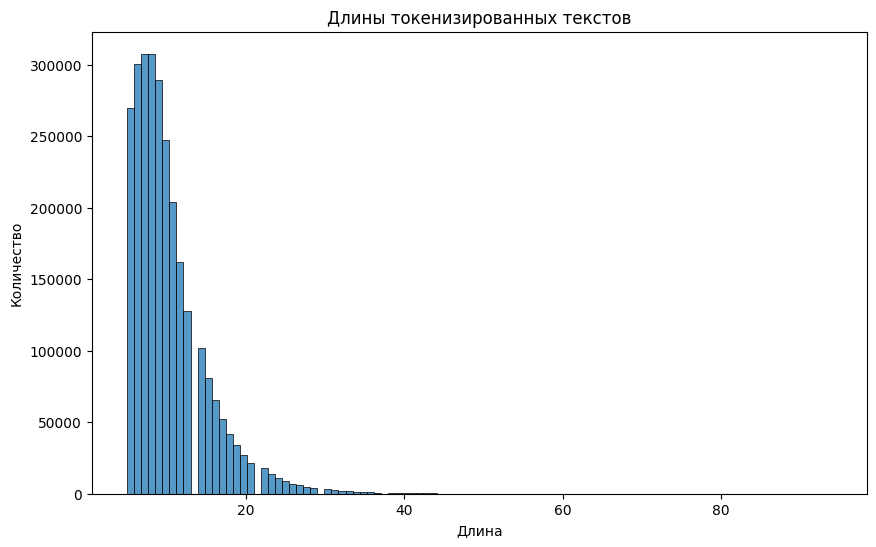

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

lens = [len(text_tokens) for text_tokens in ds._corpus]

# Визуализация
plt.figure(figsize=(10, 6))
sns.histplot(lens, bins=100)
plt.title("Длины токенизированных текстов")
plt.xlabel("Длина")
plt.ylabel("Количество")
plt.show()

In [14]:
pd.Series(lens).quantile(0.99)

27.0

Присвойте максимально допустимое значение длины:

In [10]:
MAXLEN = 30

In [11]:
#ds.set_maxlen(30)

ds = PretrainDataset(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    corpus=data["text"].tolist(),
    tokenizer=tokenizer,
    minlen=5,
    maxlen=MAXLEN,
    verbose=True, 
    presort=True
)

100%|██████████| 3155764/3155764 [01:57<00:00, 26849.39it/s]


In [12]:
tests.test_dataset(ds)

Correct.


Если для задачи **SOP** мы готовим данные при индексации датасета `PretrainDataset`, то маскирование для задачи **MLM** удобней делать в Collator'е в тензорном виде.

Как с вероятностью `15%` заменить в тензоре `input_ids` значения на `0`: 

1. `mask = torch.rand(input_ids.shape) < 0.15`
2. `input_ids = torch.where(mask, 0, input_ids)`

Как сгенерировать случайные элементы словаря на каждый элемент батча: `torch.randint_like(input_ids, low=num_special_tokens, high=self._tokenizer.vocab_size)`.

В `Collator` нужно также:
1. сделать паддинг.
2. из (примерно) 15% выбранных токенов 10% поменять на случайные и 10% оставить в исходном виде, остальные замаскировать
3. сформировать таргеты. Нам нужно понимать, какие именно 15% токенов мы выбрали для предсказания + какие были исходные метки для них.

Важно: `[CLS]` и другие специальные токены токены маскировать не надо

In [13]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def pad_sequence_with_last_value(sequences):
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = []
    
    for seq in sequences:
        num_pad = max_len - len(seq)
        last_value = seq[-1] if len(seq) > 0 else 0
        padding = seq.new_full((num_pad,), last_value)
        padded_seq = torch.cat((seq, padding), 0)
        padded_sequences.append(padded_seq)
    return torch.stack(padded_sequences)

class Collator:
    
    def __init__(
            self,
            tokenizer,
            non_target_idx=-100,
            mask_prob=0.15,
            random_prob=0.1,
            keep_unchanged_prob=0.1
    ):
        """
            tokenizer: токенизатор
            non_target_idx: значение для индексов, не использующихся как таргеты. 
                Используйте его, чтобы пометить "не таргет" токены
            mask_prob: вероятность выбрать индекс как таргет
            random_prob: вероятность для уже выбранного индекса поменять его на случайное значение вместо маскирования
            keen_unchanged_prob: вероятность оставить индекс в исходном виде вместо маскирования
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._tokenizer = tokenizer
        self.non_target_idx = non_target_idx
        self.mask_prob = mask_prob
        self.random_prob = random_prob
        self.keep_unchanged_prob = keep_unchanged_prob
        
        
    def __call__(self, batch):
        """
            batch: список вида [ds[i] for i in [12, 3, 2, 5]]
            
            returns: 
                input_ids: испорченные входные индексы токенов с замаскированными значениями
                token_type_ids: сегментные эмбеддинги
                labels: истинные значения входных индексов, как таргеты
                permuted: был ли свап сегментов
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        input_ids = []
        token_type_ids = []
        labels = []
        permuted = []
        special_tokens = [
            self._tokenizer.cls_token_id,
            self._tokenizer.pad_token_id, 
            self._tokenizer.unk_token_id,
            self._tokenizer.mask_token_id, 
            self._tokenizer.sep_token_id
        ]

        for sample in batch:
            inputs, token_type_id, permute = sample
            input_ids.append(inputs)
            token_type_ids.append(token_type_id)
            permuted.append(permute)

        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=self._tokenizer.pad_token_id)
        token_type_ids = pad_sequence_with_last_value(token_type_ids)

        labels = input_ids.clone()
        mask = (torch.rand(input_ids.shape, device=input_ids.device) < self.mask_prob) * (input_ids != self._tokenizer.cls_token_id) *\
                (input_ids != self._tokenizer.pad_token_id) * (input_ids != self._tokenizer.unk_token_id) * \
                (input_ids != self._tokenizer.mask_token_id) * (input_ids != self._tokenizer.sep_token_id)
        
        labels[~mask] = self.non_target_idx
        input_ids[mask] = self._tokenizer.mask_token_id
        
        indices_random = mask * (torch.rand(input_ids.shape, device=input_ids.device) < self.random_prob)
        random_tokens = torch.randint(low=6, high=self._tokenizer.vocab_size, size=input_ids[indices_random].shape, device=input_ids.device)
        input_ids[indices_random] = random_tokens

        indices_old = mask * (torch.rand(input_ids.shape, device=input_ids.device) < self.keep_unchanged_prob)
        input_ids[indices_old] = labels[indices_old]
        
        return input_ids, token_type_ids, labels, torch.tensor(permuted)

Создайте `collator` и `dataloader`. Для предобучения предлагается использовать большой `batch_size`.

In [14]:
collator = Collator(tokenizer, non_target_idx=-100)

dl = DataLoader(
    ds, 
    collate_fn=collator, 
    batch_size=1024, 
    shuffle=False
)

In [15]:
tests.test_collator(ds, collator)

Correct.


## Часть 2. Создание модели (2 балла)

В качестве модели мы будем использовать энкодер трансформера точь-в-точь в таком же виде, как его использовали в оригинальной статье про BERT. 

Прежде чем начать писать составляющие энкодера, обсудим инициализацию весов. Для трансформера нам понадобится большое количество линейных слов (`nn.Linear`), у которых для инициализации по дефолту используется равномерное распределение и отсутствует зануление bias'ов: $$\text{Uniform}\left(-\frac{1}{\sqrt{N_{\text{in_features}}}}, \frac{1}{\sqrt{N_{\text{in_features}}}}\right).$$

В оригинальной статье про BERT для весов используется **TruncatedNormal** со стандартным отклонением 0.02, bias'ы инициализируются нулями и модель обучается значительно лучше (это можно в ходе домашнего задания проверить).

Поэтому, после создания линейных слоев и матрицы эмбеддингов, необходимо в явном виде вызывать для них TruncatedNormal инициализацию:

1. `layer = ...`
2. `nn.init.trunc_normal_(layer.weight.data, std=0.02, a=-2 * 0.02, b=2 * 0.02)`.

Для линейных слоев нужно также вызывать `layer.bias.data.zero_()`.


**TruncatedNormal** распределение отличается от нормального тем, что если величины выходят за границы отрезка [a, b], для этих величин повторно происходит сэмплирование до тех пор, пока они не попадут в нужный отрезок. Для BERT stddev = 0.02:

$$[a; b] = [- 2  \cdot \text{stddev}; 2 \cdot \text{stddev}].$$

Напишите функцию для инициализации линейных слоев и матрицы эмбеддингов **TruncatedNormal** распределением:

In [16]:
from torch import nn


def init_layer(layer, initializer_range=0.02, zero_out_bias=True):
    """
        layer: наследник nn.Module, т.е. слой в pytorch
        initializer_range: stddev для truncated normal
        zero_out_bias: True для линейных слоев, False для матрицы эмбеддингов
    """
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Embedding):
        nn.init.trunc_normal_(layer.weight.data, mean=0.0, std=initializer_range, a=-2*initializer_range, b=2*initializer_range)
        if isinstance(layer, nn.Linear):
            layer.bias.data.zero_()

Приступим к созданию энкодера трансформера.

<img src="images/transformer.png" width=500 height=600 />

Сформируем слой, создающий входные векторы токенов. Для этого нам нужны:
1. Эмбеддинги токенов (`nn.Embedding`)
2. Позиционные эмбеддинги (можно либо использовать `nn.Embedding`, либо явно создать матрицу эмбеддингов с помощью `nn.Parameter`)
3. Сегментные эмбеддинги

Эти три сущности складываются, затем идет layernorm и dropout.

<img src="images/bert_input.png" width=800 height=600 />

In [17]:
class BertEmbeddings(nn.Module):
    
    def __init__(
            self, 
            vocab_size, 
            hidden_size, 
            max_seqlen,
            dropout_prob=0., 
            type_vocab_size=2,
            eps=1e-3
    ):
        """
            vocab_size: размер словаря
            hidden_size: размерность эмбеддингов
            max_seqlen: количество позиционных эмбеддингов
            dropout_prob: вероятность дропаута в конце слоя
            type_vocab_size: количество сегментных эмбеддингов
            eps: eps для layernorm
        """
        super().__init__()
        self._token_embeddings = nn.Embedding(vocab_size, hidden_size)
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self.position_embeddings = nn.Embedding(max_seqlen, hidden_size)
        self.sentence_embeddings = nn.Embedding(type_vocab_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size, eps)
        self.dropout = nn.Dropout(dropout_prob)
        
    def get_token_embeddings(self):
        """
            returns: возвращает слой с матрицей эмбеддингов для токенов. Нужен для MLM головы
        """
        return self._token_embeddings
    
    def forward(self, input_ids, token_type_ids=None):
        """
            input_ids: тензор с индексами токенов
            token_type_ids: сегментные индексы
            
            returns: эмбеддинги токенов
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        token_embed = self._token_embeddings(input_ids)
        pos_embed = self.position_embeddings(torch.arange(input_ids.shape[1], dtype=input_ids.dtype).unsqueeze(0).expand(input_ids.shape[0], -1).to(input_ids.device))
        if token_type_ids is not None:
            sent_embed = self.sentence_embeddings(token_type_ids)
        embed = token_embed + pos_embed + sent_embed if token_type_ids is not None else token_embed + pos_embed
        return self.dropout(self.layer_norm(embed))

In [18]:
tests.test_bert_embeddings(BertEmbeddings)

Correct. Amount of parameters is: 7746560.


Как выглядит одноголовый **SelfAttention**:
    
<img src="images/attention.png" width=600 height=200 />

Как выглядит многоголовый (multihead) **SelfAttention:**

<img src="images/multihead.png" width=200 height=200 />

Реализация **MultiHeadSelfAttention** — самая сложная часть энкодера. Дальше будет проще :)

1. Принимаем на вход посл-ть векторов для каждого объекта в батче, т.е. тензор размера `batch_size x seqlen x dim`
2. Получаем из исходных векторов векторы `query, key, value` с помощью линейного слоя. $W_q X, W_k X, W_v X$.
    * **Важно:** не нужно делать три отдельных линейных слоя. Сделайте один линейный слой в три раза шире, затем после его применения разделите результат на три части с помощью метода `.chunk`. $W_{qkv} X$.
3. Полученные query, key, value векторы делятся между "головами" аттеншна c помощью `.view`. Далее операции происходят для каждой головы отдельно.
4. Нужно посчитать скалярные произведения всех запросов (queries) со всеми ключами (keys): $QV^T$.
5. Заменить значения для паддинг токенов на очень маленькие (большие отрицательные), чтобы они не влияли на софтмакс:         
    `attention_scores = attention_mask * attention_scores + (1 - attention_mask) * -100000`

6. Применить Dropout аттеншн скоров, который  выкидывает из аттеншна токены целиком.
7. Поделить "аттеншны скоры" на корень из размерности векторов и взять софтмакс по ключам. Т.е. $\text{softmax}(\frac{QK^T}{\sqrt{d}}, \text{axis=1})$
8. Посчитать контекстные векторы запросов $\text{softmax}(\frac{QK^T}{\sqrt{d}}, \text{axis=1})V$.
9. Сконкатенировать контекстные векторы всех голов и применить линейный слой той же размерности и dropout.
10. Сложить со входом **MultiHeadSelfAttention** слоя, применить layernorm: $\text{layernorm}(x + \text{dropout}(f(x)))$.

**Про аттеншн маску:**
* В полном виде аттеншн маска имеет размерность `batch_size x seqlen x seqlen`
* У нас же если токен не паддинг, то его видят остальные токены, поэтому по сути вся информация содержится в матрице размера `batch_size x seqlen` с предикатом является ли токен паддингом
* Эту матрицу размера `batch_size x seqlen` можно привести к виду `batch_size x seqlen x seqlen` операцией вида `attention_mask[:, None] * torch.ones_like(attention_mask)[..., None]`

**Вопросы:**
1. Зачем нужно делить на корень из $d$ результаты скалярных произведений?
2. Почему одно большое умножение на матрицу лучше, чем три маленьких?
3. Что будет, если мы не будем заменять значения аттеншн скоров паддинг токенов на большие отрицательные значения?
4. Какая вычислительная сложность (количество умножений) у операции **MultiheadSelfAttention**?

**Ваши ответы напишите здесь:**
1. Чтобы сохранить дисперсию примерно равную 1 для более стабильной работы сети и процесса её обучения
2. Так более эффективно. Можно распараллелить матричное вычисление для более быстрого умножения
3. Паддинг нужен только для того, чтобы одновременно обрабатывать батч из нескольких предложений разной длины. Мы не должны обращать внимание на токены, которых по факту нет.
4. Для начала нужно вычислить k, q и v, для этого перемножаем исходную матрицу на проекционную: $(n \times D) \cdot (D \times d) = (n \times d)$. Это $O(ndD)$ операций. Затем считаем внимание: перемножаем матрицы размера $(n \times d) \cdot (d \times n) = (n \times n)$. И Затем $(n \times n) \cdot (n \times d)$. В обоих случаях это $O(n^2d)$ операций. И таких $K$ голов. Таким образом, квадратично зависит от длины последовательности и линейно для других параметров.

In [19]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    
    def __init__(
            self,
            hidden_size,
            num_attention_heads,
            attention_probs_dropout_prob=0.,
            dropout_prob=0.,
            eps=1e-3
    ):
        """
            hidden_size: размерность эмбеддингов
            num_attention_heads: количество голов аттеншна. Обычно выбирается как hidden_size / num_attention_heads = 64,
                т.е. размерность векторов у одной головы 64
            attention_probs_dropout_prob: вероятность дропаута для аттеншн скоров
            dropout_prob: вероятность дропаута в конце слоя (перед суммой со входами)
            eps: eps для layernorm
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = hidden_size // num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.qkv = nn.Linear(hidden_size, self.all_head_size*3)

        self.attn_dropout = nn.Dropout(attention_probs_dropout_prob)
        self.o_proj = nn.Linear(hidden_size, hidden_size)
        self.out_dropout = nn.Dropout(dropout_prob)
        self.layer_norm = nn.LayerNorm(hidden_size, eps)

    @property
    def size_per_head(self):
        """
            returns: размерность векторов для одной головы
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        return self.attention_head_size
    
    def forward(self, embeddings, attention_mask):
        """
            embeddings: входные эмбеддинги
            attention_mask: тензор из 0, 1 размерности batch_size x seqlen x seqlen
            
            returns: контекстные векторы
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        query, key, value = self.qkv(embeddings).chunk(chunks=3, dim=-1)
        batch_size, seq_len, _ = query.shape
        query = query.view(batch_size, seq_len, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, seq_len, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, seq_len, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        
        attention_scores = torch.matmul(query, key.transpose(2, 3)) / math.sqrt(self.attention_head_size)
        attention_mask = attention_mask.unsqueeze(1)
        attention_scores = attention_mask*attention_scores + (1 - attention_mask)*(-100000.)
        attention_scores = self.attn_dropout(attention_scores)
        
        attn_weights = F.softmax(attention_scores, dim=-1, dtype=torch.float32).to(query.dtype)
        attn_output = torch.matmul(attn_weights, value)

        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(batch_size, seq_len, -1)
        
        attn_output = self.o_proj(attn_output)
        output = self.layer_norm(self.out_dropout(attn_output) + embeddings)
        return output

In [20]:
tests.test_attention(MultiHeadSelfAttention)

Correct. Amount of parameters: 263680.


Реализовать **полносвязный слой** гораздо проще - $\text{layernorm}(\text{dropout}(W_2 f(W_1 x + b_1) + b_2) + x)$:
1. Линейный слой, расширяющий входные векторы до *intermediate_size*, который традиционно равен 4 * hidden_size, т.е. происходит расширение в четыре раза
2. Функция активации (больше вы их нигде в модели не увидите)
3. Линейный слой, сужающий векторы обратно до *hidden_size*
4. Dropout, сложение со входом полносвязного слоя, layernorm

**Вопросы:**
1. Что дает "расширение" первым линейным слоем? Нельзя ли делать линейный слой поменьше?
2. Какая вычислительная сложность (количество умножений) у операции?
3. Используются ли где-то еще в трансформере функции активации (если не считать softmax функцией активации)?

**Ваши ответы напишите здесь:**
1. Больше параметров - больше инфы можем запомнить, больше обобщающей способности. Можно и меньше, но тогда резы будут чуть похуже.
2. Сначала $(n \times hid\_size) \cdot (hid\_size \times inter\_size) = (n \times inter\_size)$. Далее наоборот $(n \times inter\_size) \cdot (inter\_size \times hid\_size) = (n \times hid\_size)$. Ну LayerNorm на $hid\_size$ операций. Таким образом, всего $O(n \cdot hid\_size \cdot inter\_size)$ операций
3. В самом конце на головке, которой предсказываем токен для задач предобучения.

In [21]:
class FeedForward(nn.Module):
    
    def __init__(
            self, 
            hidden_size, 
            intermediate_size, 
            dropout_prob=0., 
            act_func='relu', 
            eps=1e-3
    ):
        """
            hidden_size: размерность эмбеддингов
            intermediate_size: размерность промежуточно слоя. Обычно 4 * hidden_size
            dropout_prob: вероятность дропаута перед суммой со входными представлениями
            act_func: функция активации. Должны быть доступны gelu, relu
            eps: eps для layernorm
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.ReLU() if act_func.lower()=='relu' else nn.GELU(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(dropout_prob)
        )
        self.layer_norm = nn.LayerNorm(hidden_size, eps)
        
    def forward(self, embeddings):
        """
            embeddings: входные эмбеддинги размерности batch_size x seqlen x hidden_size
            
            returns: преобразованные эмбеддинги той же размерности
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        return self.layer_norm(self.mlp(embeddings) + embeddings)

In [22]:
tests.test_feedforward(FeedForward)

Correct. Amount of parameters is: 526080.


Объединим **MultiHeadSelfAttention** и **Feedforward** в один блок энкодера. Они применяются последовательно:

In [23]:
class BertLayer(nn.Module):
    
    def __init__(
            self, 
            hidden_size, 
            intermediate_size, 
            num_attention_heads, 
            dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            act_func='relu',
            eps=1e-3
    ):
        super().__init__()
        self._multihead_attention = MultiHeadSelfAttention(
            hidden_size=hidden_size,
            num_attention_heads=num_attention_heads,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            dropout_prob=dropout_prob,
            eps=eps
        )
        
        self._feedforward = FeedForward(
            hidden_size=hidden_size,
            intermediate_size=intermediate_size,
            act_func=act_func,
            eps=eps,
            dropout_prob=dropout_prob
        )
        
    def forward(self, x, attention_mask=None):
        x = self._multihead_attention(x, attention_mask)
        x = self._feedforward(x)
        return x

In [24]:
tests.test_bert_layer(BertLayer)

Correct. Amount of parameters is: 789760.


Объедините **BertEmbeddings** и произвольное заданное число **BertLayer** слоёв в один слой:

In [25]:
class Bert(nn.Module):
    
    def __init__(
            self, 
            vocab_size,
            max_seqlen,
            hidden_size,
            num_hidden_layers,
            intermediate_size, 
            num_attention_heads, 
            input_dropout_prob=0.,
            dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            act_func='relu',
            eps=1e-3
    ):
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._embeddings = BertEmbeddings(
            vocab_size, 
            hidden_size, 
            max_seqlen, 
            input_dropout_prob, 
            eps=eps
        )

        self.encoder_layers = nn.ModuleList([
            BertLayer(
                hidden_size,
                intermediate_size,
                num_attention_heads,
                dropout_prob,
                attention_probs_dropout_prob,
                act_func,
                eps
            ) for _ in range(num_hidden_layers)
        ])
        
    def get_token_embeddings(self):
        """
            returns: эмбеддинги токенов (матрицу эмбеддингов)
        """
        return self._embeddings.get_token_embeddings()
    
    @staticmethod
    def expand_mask(attention_mask):
        """
            attention_mask: маска паддинга размерности batch_size x seqlen
            
            returns: маска паддинга размерности batch_size x seqlen x seqlen
        """
        return attention_mask[:, None] * torch.ones_like(attention_mask)[..., None]
    
    def forward(self, x, attention_mask=None, token_type_ids=None):
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        embeddings = self._embeddings(x, token_type_ids)
        attention_mask = self.expand_mask(attention_mask)
        for layer in self.encoder_layers:
            embeddings = layer(embeddings, attention_mask)
        return embeddings

In [26]:
tests.test_bert(Bert)

Correct. Amount of parameters is: 10905600.


Для предобучения (и для целевых задач) необходимо задать "головы" модели:

Голова для **MLM** задачи выглядит как $W_2 \text{layernorm} (f(W_1 x + b_1)) + b_2$:
1. Линейный слой $d \times d$
2. Функция активации
3. LayerNorm
4. Линейный слой $d \times |V|$, где $|V|$ --- размер словаря. **Важно:** в качестве матрицы, на которую происходит умножение при аффинном преобразовании, берется матрица эмбеддингов токенов.
5. Функционал ошибки тоже будем считать сразу в голове, для него используется **nn.CrossEntropyLoss**: 
    * `self._criterion(preds.view(-1, self._vocab_size), labels.view(-1))`

Чтобы использовать матрицу входных эмбеддингов вместо последнего линейного слоя в голове, можно использовать присваивание вида`self._decoder.weight = input_embeddings.weight`.

In [27]:
class MlmHead(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size, 
            hidden_act, 
            eps=1e-3, 
            ignore_index=-100, 
            input_embeddings=None
    ):
        """
            hidden_size: размерность эмбеддингов
            vocab_size: размер словаря
            hidden_act: функция активации
            eps: eps для layernorm
            ignore_index: индекс таргета, который необходимо игнорировать при подсчете лосса
            input_embeddings: слой с эмбеддингами токенов, для использования матрицы эмбеддингов вместо линейного слоя
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self.ignore_index = ignore_index
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU() if hidden_act.lower()=='relu'else nn.GELU(),
            nn.LayerNorm(hidden_size, eps=eps)
        )
        self.decoder = nn.Linear(hidden_size, vocab_size)        
        if input_embeddings is not None:
            self.decoder.weight = input_embeddings.weight
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)

    def forward(self, hidden_states, labels):
        """
            hidden_states: эмбеддинги токенов
            labels: истинные метки, т.е. изначальные индексы токенов
            
            returns: посчитанный лосс
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        # self.criterion(preds.view(-1, preds.size(-1)), labels.view(-1))
        labels = labels.view(-1)
        preds = self.decoder(self.mlp(hidden_states))
        preds = preds.view(-1, preds.size(-1))
        loss = self.criterion(preds, labels)
        return loss

In [28]:
tests.test_mlm_head(MlmHead, BertEmbeddings)

Correct. Amount of parameters is: 7776304.


Голова для **SOP**-задачи выглядит аналогично и в оригинальной статье называется "pooler-слоем":
1. Берем скрытое представление CLS токена
2. Линейный слой $d \times d$
3. Функция активации, причем в качестве функции активации используется гиперболический тангенс **nn.Tanh**
4. Dropout
5. Линейный слой
6. Функционал ошибки (бинарная кросс-энтропия с логитами, **nn.BCEWithLogitsLoss**)

Эту голову (кроме последнего линейного слоя) мы будем использовать также и для целевой задачи (классификации чеков).

In [29]:
class ClassifierHead(nn.Module):
    CLS_POSITION = 0
    CRITERION = nn.BCEWithLogitsLoss()
    
    def __init__(self, hidden_size, num_classes=1, hidden_dropout_prob=0.):
        """
            hidden_size: размерность эмбеддингов
            hidden_dropout_prob: вероятность дропаута
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Dropout(hidden_dropout_prob),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, hidden_states, permuted=None):
        """
            hidden_states: эмбеддинги
            permuted: таргеты (были ли свапы сегментов). Если их нет, то необходимо выдать предсказания
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        cls_token = hidden_states[:, self.CLS_POSITION, :]
        pred = self.mlp(cls_token)
        if permuted is not None:
            loss = self.CRITERION(pred.view(-1, 1), permuted.view(-1, 1).float())
            return loss
        return pred

In [30]:
tests.test_classifier_head(ClassifierHead)

Correct. Amount of parameters is: 66049.


Объединим **Bert**, **MlmHead** и **ClassifierHead** в единую модель:

In [31]:
class BertModel(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size,
            max_seqlen,
            num_hidden_layers,
            intermediate_size,
            num_attention_heads,
            act_func='relu',
            input_dropout_prob=0.,
            hidden_dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            eps=1e-3, 
            ignore_index=-100
    ):
        super().__init__()
        self._backbone = Bert(
            vocab_size=vocab_size,
            max_seqlen=max_seqlen,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            intermediate_size=intermediate_size, 
            num_attention_heads=num_attention_heads, 
            input_dropout_prob=input_dropout_prob,
            dropout_prob=hidden_dropout_prob, 
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            act_func=act_func,
            eps=eps
        )
        self._mlm_head = MlmHead(
            hidden_size, 
            vocab_size, 
            act_func, 
            eps, 
            ignore_index, 
            input_embeddings=self._backbone.get_token_embeddings()
        )
        self._classifier_head = ClassifierHead(
            hidden_size, 
            hidden_dropout_prob=hidden_dropout_prob, 
            num_classes=1
        )

    def forward(self, x, attention_mask, labels, permuted, token_type_ids=None):
        hidden_states = self._backbone(x, attention_mask, token_type_ids)
        mlm_loss = self._mlm_head(hidden_states, labels)
        sop_loss = self._classifier_head(hidden_states, permuted)
        # в оригинальном BERT лоссы MLP и NSP используются с равными весами
        return 0.5 * mlm_loss + 0.5 * sop_loss, {'MLM': mlm_loss, 'SOP': sop_loss}

Значения гиперпараметров:
* для успешного выполнения задания достаточно архитектуры bert-mini: `hidden_size=256`, `num_hidden_layers=4`, в качестве функции активации можно использовать `gelu`
* стандартные практики: `intermediate_size = 4 * hidden_size`, `num_attention_heads = hidden_size // 64`
* в оригинальной статье везде dropout равен 0.1, но для bert-mini модели можно попробовать значения поменьше. Вопрос - почему?

In [32]:
model = BertModel(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    hidden_size=256, 
    vocab_size=tokenizer.vocab_size,
    max_seqlen=30,
    num_hidden_layers=4,
    intermediate_size=1024,
    num_attention_heads=4,
    act_func='gelu',
    input_dropout_prob=0.05,
    hidden_dropout_prob=0.05, 
    attention_probs_dropout_prob=0.05,
    eps=1e-3, 
    ignore_index=-100
)

In [33]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                             Param #
BertModel                                          --
├─Bert: 1-1                                        --
│    └─BertEmbeddings: 2-1                         --
│    │    └─Embedding: 3-1                         7,680,000
│    │    └─Embedding: 3-2                         7,680
│    │    └─Embedding: 3-3                         512
│    │    └─LayerNorm: 3-4                         512
│    │    └─Dropout: 3-5                           --
│    └─ModuleList: 2-2                             --
│    │    └─BertLayer: 3-6                         789,760
│    │    └─BertLayer: 3-7                         789,760
│    │    └─BertLayer: 3-8                         789,760
│    │    └─BertLayer: 3-9                         789,760
├─MlmHead: 1-2                                     --
│    └─Sequential: 2-3                             --
│    │    └─Linear: 3-10                           65,792
│    │    └─GELU: 3-11                   

**Вопросы:**
1. Какая часть модели содержит наибольшее количество параметров? Эмбеддинги, аттеншн, полносвязные слои, голова?
2. Зачем объединять параметры в голове и параметры матрицы эмбеддингов?

**Ваши ответы напишите здесь:**
1. Судя по саммари сверху больше всего весов в голове (хотя в эмбеддингах не шибко меньше). Это потому, что у нас и там и там есть огромная матрица размера $d \times |V|$, где $|V|$ --- размер словаря, которая сжирает дофига параметров.
2. Как было замечено раннее у нас эта матрица занимает очень много весов. Тем более голова на выходе нужна только для предобучения, потом мы её выкинем, поэтому нет смысла тратить на её обучение ресурсы. Плюс таким образом мы можем довольно хорошо обучить начальную матрицу эмбеддингов. Процесс обучения будет намного стабильнее.

## Часть 3. Оптимизация (1 балл)

Для оптимизации будем использовать **AdamW**, отличия которого от ванильного **Adam** можно почитать, например, [вот здесь](https://towardsdatascience.com/why-adamw-matters-736223f31b5d)

Параметры модели, передаваемые в оптимизатор, следует поделить на две группы с помощью `model.named_parameters()`:
1. Все `bias` и `layernorm` слои, присутствующие в модели (их можно выцепить по названию). Для них $l_2$ регуляризацию стоит выключить, т.е. поставить `weight_decay=0`
2. Оставшиеся слои, для которых регуляризация не нужна.


**Вопрос:** почему $l_2$ регуляризацию не используют для bias'ов? Для layernorm?

In [34]:
def get_optimizer(model, weight_decay=0.01):
    """
    model: инициализированная модель
    weight_decay: коэффициент l2 регуляризации

    returns: оптимизатор
    """
    decayed_parameters, not_decayed_parameters = [], []
    
    for name, param in model.named_parameters():
        if 'bias' in name or 'LayerNorm.weight' in name:
            not_decayed_parameters.append(param)
        else:
            decayed_parameters.append(param)
    
    grouped_parameters = [
        {'params': decayed_parameters, 'weight_decay': weight_decay},
        {'params': not_decayed_parameters, 'weight_decay': 0.}
    ]

    return torch.optim.AdamW(grouped_parameters)

In [35]:
optimizer = get_optimizer(model)

In [36]:
tests.test_optimizer(get_optimizer, model)

Correct.


Как выглядит типичное расписание lr для трансформеров:

<img src="images/lr.png" width=300 height=300 />

Почему мы сразу не стартуем с большого значения lr? Для больших архитектур трансформера модель разойдется, произойдет взрыв градиентов. Постепенно же увеличить lr до большого значения — можно. Процедуру линейного увеличения lr до какого-то пикового значения называют `linear warmup`.

Реализуйте такое "треугольное" расписание для learning rate в предложенном шаблоне.

**Вопрос:** а зачем нужно убывание learning rate?

In [37]:
class Scheduler:
    
    def __init__(
            self, 
            optimizer, 
            init_lr, 
            peak_lr, 
            final_lr, 
            num_warmup_steps, 
            num_training_steps
    ):
        """
            optimizer: оптимизатор
            init_lr: начальное значение learning rate
            peak_lr: пиковое значение learning rate
            final_lr: финальное значение lr
            num_warmup_steps: количество шагов разогрева (сколько шагов идем от начального до пикового значения)
            num_training_steps: количество шагов обучения (количество батчей x количество эпох)
            
        """
        self._optimizer = optimizer
        self._step = 0
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._init_lr = init_lr
        self.lr = init_lr
        self._peak_lr = peak_lr
        self._final_lr = final_lr
        self._num_warmup_steps = num_warmup_steps
        self._num_training_steps = num_training_steps

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = init_lr
        
    def step(self):
        """
            Меняет learning rate для оптимизатора
            
            Поменять learning rate для группы параметров в оптимизаторе можно присваиванием вида param_group['lr'] = lr
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        
        if self._step < self._num_warmup_steps:
            self.lr += (self._peak_lr - self._init_lr) / self._num_warmup_steps
        else:
            self.lr -= (self._peak_lr - self._final_lr) / (self._num_training_steps - self._num_warmup_steps)
        
        # Обновляем learning rate для каждой группы параметров
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = self.lr
        
        self._step += 1
        
    def get_last_lr(self):
        """
            returns: текущий learning rate оптимизатора. Нужно для логгирования
        """
        return [param_group['lr'] for param_group in self._optimizer.param_groups]

In [38]:
tests.test_scheduler(Scheduler, get_optimizer, model)

Correct.


От запуска обучения нас отделяет только создание `Trainer`. От объектов класса `Trainer` требуется, чтобы:
* логгировался лосс на каждом батче (`torch.utils.tensorboard.SummaryWriter`, `writer.add_scalar`)
* клипались и логгировались нормы градиентов при каждом шаге спуска (`orch.nn.utils.clip_grad_norm_` возвращает нормы градиентов)
* логгировались значения learning rate
* была поддержана аккумуляция градиентов, нужная для эмуляции больших батчей

При предобучении не нужно использовать какую-либо форму валидации, достаточно смотреть на батч лосс.

Предлагается также для ускорения обучения использовать mixed precision из библиотеки `apex`:
* перед обучением необходимо вызвать строчку вида `model, optimizer = amp.initialize(model, optimizer, opt_level='O1')`
* при обучении `.backward()` надо делать в контекстном менеджере:     
   `with amp.scale_loss(loss, optimizer) as scaled_loss: scaled_loss.backward()`
        
Что такое аккумуляция градиентов:
* При использовании Adam в видеопамяти необходимо хранить градиенты и квадраты частных производных
* При подсчете градиента по очередному батчу необязательно сразу делать шаг спуска, можно запомнить градиент, а затем посчитать градиент по другому батчу c теми же параметрами модели
* Теперь эти два градиента можно сложить и получить градиент, который был посчитан как будто по одному большому батчу (составленному из этих двух). Сэмулировали большой батч. В данном случае количество шагов аккумуляции равно двум.
* В данном случае количество шагов аккумуляции равно двум.

Зачем нужны большие батчи? Обучение быстрее, оценки градиента точнее, позволяет увеличивать learning rate. Например, при предобучении авторы RoBERTA значительно увеличили размер батча по сравнению с ванильным BERT и получили прирост к качеству решения целевых задач.

In [39]:
import os
import shutil
from collections import defaultdict

from apex import amp

import torch
from torch.utils.tensorboard import SummaryWriter


class Trainer:

    def __init__(
            self, 
            model, 
            optimizer, 
            scheduler,
            pad_token_id,
            device,
            num_accum_steps=1,
            logdir=None,
            max_grad_norm=None,
    ):
        """
            model: объект класса BertModel
            optimizer: оптимизатор
            scheduler: расписание learning rate. Нужно вызывать scheduler.step() ПОСЛЕ optimizer.step()
            pad_token_id: индекс паддинга. Нужен для создания attention mask
            device: девайс (cpu или cuda), на котором надо производить вычисления
            num_accum_steps: количество шагов аккумуляции
            logdir: директория для записи логов
            max_grad_norm: максимум нормы градиентов, для клиппинга
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self.model = model.to(device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.pad_token_id = pad_token_id
        self.device = device
        self.num_accum_steps = num_accum_steps
        self.max_grad_norm = max_grad_norm
        self._n_epoch = 0
        self.step = 0
        self.global_step = 0
        
        self.writer = SummaryWriter(logdir) if logdir else None
        self.model.to(device)
        
    def train(self, dataloader, n_epochs):
        for epoch in range(n_epochs):
            self._train_step(dataloader)
            self._n_epoch += 1

    def _train_step(self, dataloader):
        """
            dataloader: объект класса DataLoader для обучения
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self.model.train()
        
        loss_accum = 0.0
        self.optimizer.zero_grad()
        for step, batch in tqdm(enumerate(dataloader), ascii=True):
            input_ids, token_type_ids, labels, permuted = batch
            input_ids = input_ids.int().to(self.device)
            token_type_ids = token_type_ids.int().to(self.device)
            labels = labels.long().to(self.device)
            permuted = permuted.to(self.device)
            attention_mask = (input_ids != self.pad_token_id).float()

            loss, dict_loss = self.model(input_ids, attention_mask, labels, permuted, token_type_ids)
            loss_accum += loss / self.num_accum_steps

            if (step + 1) % self.num_accum_steps == 0:
                # with amp.scale_loss(loss_accum, self.optimizer) as scaled_loss:
                #     scaled_loss.backward()
                loss_accum.backward()
                
                if self.max_grad_norm is not None:
                    grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
                    self.writer.add_scalar("Gradient Norm", grad_norm.detach().cpu(), self.global_step)
                
                self.optimizer.step()
                self.scheduler.step()
                
                self.optimizer.zero_grad()
                loss_accum = 0
                self.global_step += 1
                
            self.writer.add_scalar("Loss train", loss.item(), self.step)
            self.writer.add_scalar("MLM Loss train", dict_loss["MLM"].item(), self.step)
            self.writer.add_scalar("SOP Loss train", dict_loss["SOP"].item(), self.step)
            self.writer.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], self.global_step)

            self.step += 1

Обучите и сохраните предобученную модель с помощью `torch.save`. 

**Важно:** тензорборд логи успешного обучения необходимо сложить в архив и приложить вместе с решенным заданием.

Про гиперпараметры:
* `weight_decay` - $0.1, 0.01, 0.001$ и т.д.
* расписание lr - bert-mini не очень чувствителен к линейному вормапу, поэтому существенное влияние оказывают только пиковое и финальное значение lr. Пиковое значение стоит поискать где-то в масштабе 1e-3 - 1e-4, финальный lr можно сделать очень маленьким.
* конкретное значение для клиппинга нормы особо ни на что не влияет, как правило (и в оригинальной статье тоже) его всегда ставят единицой

In [40]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [41]:
model = BertModel(
    hidden_size=256, 
    vocab_size=tokenizer.vocab_size,
    max_seqlen=MAXLEN+2,
    num_hidden_layers=4,
    intermediate_size=1024,
    num_attention_heads=4,
    act_func='gelu',
    input_dropout_prob=0.1,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1,
    eps=1e-3, 
    ignore_index=-100,
).to(device)
model.apply(init_layer)

BertModel(
  (_backbone): Bert(
    (_embeddings): BertEmbeddings(
      (_token_embeddings): Embedding(30000, 256)
      (position_embeddings): Embedding(32, 256)
      (sentence_embeddings): Embedding(2, 256)
      (layer_norm): LayerNorm((256,), eps=0.001, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder_layers): ModuleList(
      (0-3): 4 x BertLayer(
        (_multihead_attention): MultiHeadSelfAttention(
          (qkv): Linear(in_features=256, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (o_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((256,), eps=0.001, elementwise_affine=True)
        )
        (_feedforward): FeedForward(
          (mlp): Sequential(
            (0): Linear(in_features=256, out_features=1024, bias=True)
            (1): GELU(approximate='none')
            (2): Linear

In [42]:
optimizer = get_optimizer(model, weight_decay=1e-2)

In [43]:
len(dl)

2668

In [44]:
n_epochs = 30

scheduler = Scheduler(
    optimizer=optimizer, 
    init_lr=1e-5, 
    peak_lr=1e-4, 
    final_lr=1e-8, 
    num_warmup_steps=int(len(dl)*0.1), 
    num_training_steps=len(dl)*n_epochs // 2
)

In [45]:
# model, optimizer = amp.initialize(model, optimizer, opt_level='O1')

In [46]:
trainer = Trainer(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    model=model, 
    optimizer=optimizer,
    scheduler=scheduler,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
    num_accum_steps=2,
    logdir="logs_pretrain",
    max_grad_norm=1,
)

In [47]:
trainer.train(dl, n_epochs=n_epochs)
    
torch.save(
    model.state_dict(),
    'pretrained_weights.pt'
)

2668it [02:16, 19.53it/s]
2668it [02:16, 19.54it/s]
2668it [02:14, 19.83it/s]
2668it [02:18, 19.25it/s]
2668it [02:18, 19.32it/s]
2668it [02:17, 19.42it/s]
2668it [02:15, 19.70it/s]
2668it [02:20, 19.00it/s]
2668it [02:20, 18.98it/s]
2668it [02:19, 19.16it/s]
2668it [02:20, 18.94it/s]
2668it [02:18, 19.30it/s]
2668it [02:18, 19.26it/s]
2668it [02:18, 19.33it/s]
2668it [02:18, 19.29it/s]
2668it [02:17, 19.36it/s]
2668it [02:17, 19.41it/s]
2668it [02:18, 19.31it/s]
2668it [02:18, 19.33it/s]
2668it [02:23, 18.56it/s]
2668it [02:18, 19.24it/s]
2668it [02:17, 19.38it/s]
2668it [02:16, 19.50it/s]
2668it [02:18, 19.31it/s]
2668it [02:17, 19.42it/s]
2668it [02:18, 19.28it/s]
2668it [02:17, 19.36it/s]
2668it [02:17, 19.39it/s]
2668it [02:22, 18.71it/s]
2668it [02:16, 19.49it/s]


После предобучения вам придется перезапустить ноутбук и снова перепрогнать блоки, нужные для дообучения. Использование apex'а ломает обучение других моделей (которые не передавались в `amp.initialize`) в одном запуске. Если не перезапустить, скор получится гораздо хуже.

## Часть 4. Дообучение (5 баллов)

Самая сложная часть уже позади, осталось чуть-чуть :)

Так как для дообучения доступно гораздо меньше данных, оно занимает гораздо меньше времени.

In [48]:
train = data.loc[data['split'] == 'train'].reset_index(drop=True).copy()
val = data.loc[data['split'] == 'val'].reset_index(drop=True).copy()
test = data.loc[data['split'] == 'test'].reset_index(drop=True).copy()

In [49]:
train.shape, val.shape, test.shape, data.shape

((38608, 3), (4826, 3), (4827, 3), (3155764, 3))

Датасет для дообучения выглядит стандартно: нужно токенизировать и запомнить тексты и соответствующие им метки, и затем в методе `__getitem__` их выдавать:

In [50]:
class FinetuneDataset(Dataset):
    
    def __init__(
            self, 
            texts, 
            targets, 
            tokenizer,
            maxlen, 
            presort=False,
            verbose=True,
    ):
        """
            texts: list of strings. Тексты чеков
            targets: list of ints. Категории товаров
            tokenizer: токенизатор
            maxlen: максимальная длина текста
            presort: отсортировать тексты по длине
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._tokenizer = tokenizer
        self._maxlen = maxlen
        self.verbose = verbose
        self.presort = presort

        self._texts = []
        self._targets = []
        for text, target in tqdm(zip(texts, targets), disable = not verbose):
            tokens = tokenizer(text)
            if len(tokens) <= maxlen:
                self._texts.append(tokens)
                self._targets.append(target)
                
        if presort:
            sorted_lists = sorted(zip(self._texts, self._targets), key=lambda x: len(x[0]))
            self._texts, self._targets = zip(*sorted_lists)
            # self._texts.sort(key=len)
        
    def __len__(self):
        return len(self._texts)
    
    def __getitem__(self, idx):
        """
            returns: input_ids - индексы токенов токенизированного текста, target - категория
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        input_ids, target = self._texts[idx], self._targets[idx]
        return input_ids, target

Создайте датасеты для обучения и валидации:

In [51]:
train_ds = FinetuneDataset(
    train['text'].values, 
    train['label'].values, 
    maxlen=30, 
    tokenizer=tokenizer
)
val_ds = FinetuneDataset(
    val['text'].values, 
    val['label'].values, 
    maxlen=30, 
    tokenizer=tokenizer, 
    presort=True
)

38608it [00:01, 29798.12it/s]
4826it [00:00, 29715.70it/s]


Коллатор для дообучения делает только паддинг и конвертацию таргетов в тензоры:

In [52]:
def collate_fn(batch, pad_idx):
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    input_ids = []
    targets = []
    for sample in batch:
        text, target = sample
        input_ids.append(torch.tensor(text))
        targets.append(target)
    input_ids_pad = pad_sequence(input_ids, batch_first=True, padding_value=pad_idx)
    return input_ids_pad, torch.tensor(targets)

Создайте даталоадеры для обучения и валидации:

In [53]:
BATCH_SIZE = 64

dataloaders = {
    'train': DataLoader(
        train_ds,
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        collate_fn=lambda batch: collate_fn(batch, tokenizer.pad_token_id)
    ),
    'eval': DataLoader(
        val_ds,
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=lambda batch: collate_fn(batch, tokenizer.pad_token_id)
    )
}

В модели теперь отсутствует MLM голова, а вместо SOP задачи голова классификации решает задачу определения категорий товаров.

In [54]:
class BertFinetuneModel(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size, 
            max_seqlen,
            num_hidden_layers,
            intermediate_size,
            num_attention_heads,
            num_classes,
            act_func='relu',
            input_dropout_prob=0.,
            hidden_dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            eps=1e-3
    ):
        super().__init__()
        self._backbone = Bert(
            vocab_size=vocab_size,
            max_seqlen=max_seqlen,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            intermediate_size=intermediate_size, 
            num_attention_heads=num_attention_heads, 
            input_dropout_prob=input_dropout_prob,
            dropout_prob=hidden_dropout_prob, 
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            act_func=act_func,
            eps=eps
        )
        self._classifier_head = ClassifierHead(hidden_size, num_classes, hidden_dropout_prob)

    def forward(self, x, attention_mask):
        hidden_states = self._backbone(x, attention_mask)
        return self._classifier_head(hidden_states)

Используйте ту же архитектуру, которую вы выбрали при предобучении. Количество классов - 96:

In [56]:
model = BertFinetuneModel(
    hidden_size=256, 
    vocab_size=tokenizer.vocab_size,
    max_seqlen=MAXLEN+2,
    num_hidden_layers=4,
    intermediate_size=1024,
    num_attention_heads=4,
    num_classes=96,
    act_func='gelu',
    input_dropout_prob=0.1,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1,
    eps=1e-3, 
).to(device)
model.apply(init_layer)

BertFinetuneModel(
  (_backbone): Bert(
    (_embeddings): BertEmbeddings(
      (_token_embeddings): Embedding(30000, 256)
      (position_embeddings): Embedding(32, 256)
      (sentence_embeddings): Embedding(2, 256)
      (layer_norm): LayerNorm((256,), eps=0.001, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder_layers): ModuleList(
      (0-3): 4 x BertLayer(
        (_multihead_attention): MultiHeadSelfAttention(
          (qkv): Linear(in_features=256, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (o_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((256,), eps=0.001, elementwise_affine=True)
        )
        (_feedforward): FeedForward(
          (mlp): Sequential(
            (0): Linear(in_features=256, out_features=1024, bias=True)
            (1): GELU(approximate='none')
            (2)

Подгрузить предобученные веса можно с помощью следующей функции:

In [57]:
def load_weights(self, path):
    found = []
    with open(path, 'rb') as f:
        weights = torch.load(f)
    for name, param in weights.items():
        if name in self.state_dict():
            if param.shape == self.state_dict()[name].shape:
                self.state_dict()[name].copy_(param)
                found.append(name)

    return found

found = load_weights(model, 'pretrained_weights.pt')

print('Amount of found weights: {}'.format(len(found)))

Amount of found weights: 55


Создайте оптимизатор и расписание лр. Про гиперпараметры:
* при дообучении используют маленький batch_size $\in \{32, 64\}$
* маленький learning rate:  $\{1e-5, 2e-5, 4e-5\}$ для больших моделей, для моделей вида bert-mini можно использовать и побольше: $\{1e-4, 2e-4, 4e-4\}$ 
* финальное значение все также маленькое
* вормап можно делать где-то 0.06 от всех шагов обучения
* количество эпох для дообучения - больше шести здесь не нужно
* weight decay здесь потенциально можно использовать побольше, чем при предобучении

In [58]:
optimizer = get_optimizer(model, weight_decay=1e-2)
n_epochs = 10

scheduler = Scheduler(
    optimizer=optimizer, 
    init_lr=1e-6, 
    peak_lr=2e-5, 
    final_lr=1e-9, 
    num_warmup_steps=int(len(dl)*0.05), 
    num_training_steps=len(dl)*n_epochs // 2
)

Осталось создать пайплайн обучения:
* apex использовать не нужно, дообучение быстрое и не требует больших батчей
* аккумуляция градиентов не нужна т.к. батчи  маленькие
* лосс теперь считается вне модели, в Trainer нужно использовать torch.nn.CrossEntropyLoss

In [59]:
class FinetuneTrainer:

    def __init__(
            self, 
            model, 
            optimizer, 
            scheduler,
            pad_token_id,
            device,
            logdir=None,
            max_grad_norm=None
    ):
        """
            model: объект класса BertModel
            optimizer: оптимизатор
            scheduler: расписание learning rate. Нужно вызывать scheduler.step() ПОСЛЕ optimizer.step()
            pad_token_id: индекс паддинга. Нужен для создания attention mask
            device: девайс (cpu или cuda), на котором надо производить вычисления
            num_accum_steps: количество шагов аккумуляции
            logdir: директория для записи логов
            max_grad_norm: максимум нормы градиентов, для клиппинга
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.pad_token_id = pad_token_id
        self.device = device
        self.max_grad_norm = max_grad_norm

        self.model = self.model.to(device)
        self.writer = SummaryWriter(logdir) if logdir else None
        self.criterion = nn.CrossEntropyLoss()
        self.step = 0
        self._n_epoch = 0

    def train(self, dataloaders, n_epochs, scorer=None):
        """
            dataloaders: dict of dataloaders, keys 'train', 'eval' should be present.
            n_epochs: int. Num epochs to train for.
            scorer: takes trainer, outputs metric name and value as a tuple.
        """
        for epoch in range(n_epochs):
            train_loss = self._train_step(dataloaders['train'])
            val_loss = self._eval_step(dataloaders['eval'])

            if self.writer is not None:
                self.writer.add_scalar('eval', val_loss, global_step=self._n_epoch)
                
                if scorer is not None:
                    name, value = scorer(self)
                    self.writer.add_scalar(name, value, global_step=self._n_epoch)
                    
            self._n_epoch += 1

    def _train_step(self, dataloader):
        """
            dataloader: training dataloader.
            
            returns: train_loss
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self.model.train()
        
        total_loss = 0.0
        for step, batch in tqdm(enumerate(dataloader)):
            self.optimizer.zero_grad()
            
            input_ids, targets = batch
            input_ids = input_ids.to(self.device)
            targets = targets.to(self.device)
            attention_mask = (input_ids != self.pad_token_id).float()

            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, targets)
            loss.backward()

            _, predicted = torch.max(outputs, 1)
            correct = (predicted == targets).sum().item()
            accuracy = correct / len(targets)
                
            if self.max_grad_norm is not None:
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
                self.writer.add_scalar("Gradient Norm", grad_norm.detach().cpu(), self.step)
                
            self.optimizer.step()
            self.scheduler.step()
                
            self.writer.add_scalar("Loss train", loss.item(), self.step)
            self.writer.add_scalar("Accuracy train", accuracy, self.step)
            self.writer.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], self.step)

            self.step += 1
            total_loss += loss.item()
        return total_loss / len(dataloader)


    def _eval_step(self, dataloader):
        """
            dataloader: evaluation dataloader.
            
            returns: eval loss
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        model.eval()
        total_loss = 0.0
        predicted_all, targets_all = np.array([]), np.array([])
        with torch.no_grad():
            for batch in dataloader:
                input_ids, targets = batch
                input_ids = input_ids.to(self.device)
                targets = targets.to(self.device)
                attention_mask = (input_ids != self.pad_token_id).float()
    
                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, targets)
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                targets_all = np.append(targets_all, targets.detach().cpu().numpy())
                predicted_all = np.append(predicted_all, predicted.detach().cpu().numpy())
        
        correct = (predicted_all == targets_all).sum()
        accuracy = correct / len(targets_all)
        self.writer.add_scalar("Accuracy val", accuracy, self._n_epoch)
        return total_loss / len(dataloader)
        
    def predict(self, dataloader):
        """
            dataloader: inference dataloader. Should not have targets.
            
            returns: np.array c предсказанными категориями
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        predicted_all = np.array([])
        for input_ids in dataloader:
            input_ids = input_ids.to(self.device)
            attention_mask = (input_ids != self.pad_token_id).float()

            outputs = self.model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            predicted_all = np.append(predicted_all, predicted.detach().cpu().numpy())
        return predicted_all

Для мониторинга целевой метрики используйте предоставленный scorer:

In [60]:
from sklearn.metrics import f1_score


class InferenceDataset(Dataset):
    
    def __init__(self, texts, maxlen, tokenizer):
        """
            texts: list of str. Сырые тексты чеков
            maxlen: максимальная длина текста
            tokenizer: токенизатор
        """
        self._texts = [tokenizer(text) if tokenizer is not None else text for text in texts]
        self._maxlen = maxlen
        
    def __len__(self):
        return len(self._texts)
    
    def __getitem__(self, idx):
        """
            returns: тензор из индексов токенов токенизированного текста
        """
        text = self._texts[idx]
        if self._maxlen is not None:
            text = text[:self._maxlen]
        return torch.tensor(text, dtype=torch.long)
    
def make_scorer(texts, targets, tokenizer, maxlen):
    inference_ds = InferenceDataset(texts, maxlen=maxlen, tokenizer=tokenizer)
    inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False, collate_fn=inference_collate_fn)
    def get_score(trainer):
        preds = trainer.predict(inference_dl)
        return 'f1', f1_score(targets, preds, average='weighted')
    return get_score


inference_collate_fn = lambda x: pad_sequence(x, batch_first=True, padding_value=tokenizer.pad_token_id)

val_scorer = make_scorer(val['text'].values, val['label'].values, tokenizer, maxlen=30)

### Инициализация претрейном, файн-тюн 1 эпоха

In [91]:
model = model = BertFinetuneModel(
    hidden_size=256, 
    vocab_size=tokenizer.vocab_size,
    max_seqlen=MAXLEN+2,
    num_hidden_layers=4,
    intermediate_size=1024,
    num_attention_heads=4,
    num_classes=96,
    act_func='gelu',
    input_dropout_prob=0.1,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1,
    eps=1e-3, 
).to(device)

found = load_weights(model, 'pretrained_weights.pt')
print('Amount of found weights: {}'.format(len(found)))

Amount of found weights: 55


In [92]:
optimizer = get_optimizer(model, weight_decay=1e-2)
n_epochs = 1

scheduler = Scheduler(
    optimizer=optimizer, 
    init_lr=5e-6, 
    peak_lr=4e-5, 
    final_lr=1e-9, 
    num_warmup_steps=int(len(dl)*0.05), 
    num_training_steps=len(dl)*n_epochs
)

In [93]:
device = torch.device('cuda')

trainer = FinetuneTrainer(
    model=model, 
    optimizer=optimizer, 
    scheduler=scheduler,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
    logdir=f"logs_ft/fine-tune {n_epochs} epochs",
    max_grad_norm=1.,
)

In [94]:
val_scorer(trainer)

('f1', 0.0018818747300944601)

In [95]:
trainer.train(dataloaders, n_epochs=n_epochs, scorer=val_scorer)
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=30)

test_scorer(trainer)

602it [00:04, 144.29it/s]


('f1', 0.561665532006793)

### Инициализация претрейном, файн-тюн 10 эпох

In [96]:
model = model = BertFinetuneModel(
    hidden_size=256, 
    vocab_size=tokenizer.vocab_size,
    max_seqlen=MAXLEN+2,
    num_hidden_layers=4,
    intermediate_size=1024,
    num_attention_heads=4,
    num_classes=96,
    act_func='gelu',
    input_dropout_prob=0.1,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1,
    eps=1e-3, 
).to(device)

found = load_weights(model, 'pretrained_weights.pt')
print('Amount of found weights: {}'.format(len(found)))

Amount of found weights: 55


In [97]:
optimizer = get_optimizer(model, weight_decay=1e-2)
n_epochs = 10

scheduler = Scheduler(
    optimizer=optimizer, 
    init_lr=5e-6, 
    peak_lr=4e-5, 
    final_lr=1e-9, 
    num_warmup_steps=int(len(dl)*0.05), 
    num_training_steps=len(dl)*n_epochs
)

In [98]:
device = torch.device('cuda')

trainer = FinetuneTrainer(
    model=model, 
    optimizer=optimizer, 
    scheduler=scheduler,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
    logdir=f"logs_ft/fine-tune {n_epochs} epochs",
    max_grad_norm=1.,
)

Скор на валидационной выборке до обучения:

In [99]:
val_scorer(trainer)

('f1', 0.013726065922180659)

In [100]:
trainer.train(dataloaders, n_epochs=n_epochs, scorer=val_scorer)

602it [00:04, 140.96it/s]
602it [00:04, 144.14it/s]
602it [00:04, 142.85it/s]
602it [00:04, 148.26it/s]
602it [00:04, 144.69it/s]
602it [00:04, 146.86it/s]
602it [00:04, 144.57it/s]
602it [00:04, 144.74it/s]
602it [00:04, 145.33it/s]
602it [00:04, 142.69it/s]


Одним из критериев получения полного балла за задание является получение на тесте значения метрики $\geqslant 0.7$. Скор на тестовой выборке:

In [101]:
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=30)

test_scorer(trainer)

('f1', 0.8103909052489793)

Не забудьте также приложить вместе со сделанным заданием тензорборд дообучения.

### Инициализация претрейном, файн-тюн 50 эпох

In [106]:
model = model = BertFinetuneModel(
    hidden_size=256, 
    vocab_size=tokenizer.vocab_size,
    max_seqlen=MAXLEN+2,
    num_hidden_layers=4,
    intermediate_size=1024,
    num_attention_heads=4,
    num_classes=96,
    act_func='gelu',
    input_dropout_prob=0.1,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1,
    eps=1e-3, 
).to(device)

found = load_weights(model, 'pretrained_weights.pt')
print('Amount of found weights: {}'.format(len(found)))

Amount of found weights: 55


In [107]:
optimizer = get_optimizer(model, weight_decay=1e-2)
n_epochs = 50

scheduler = Scheduler(
    optimizer=optimizer, 
    init_lr=5e-6, 
    peak_lr=4e-5, 
    final_lr=1e-9, 
    num_warmup_steps=int(len(dl)*0.05), 
    num_training_steps=len(dl)*n_epochs
)

In [108]:
device = torch.device('cuda')

trainer = FinetuneTrainer(
    model=model, 
    optimizer=optimizer, 
    scheduler=scheduler,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
    logdir=f"logs_ft/fine-tune {n_epochs} epochs",
    max_grad_norm=1.,
)

In [109]:
trainer.train(dataloaders, n_epochs=n_epochs, scorer=val_scorer)

602it [00:05, 110.95it/s]
602it [00:09, 66.08it/s] 
602it [00:06, 86.29it/s] 
602it [00:04, 142.09it/s]
602it [00:04, 144.48it/s]
602it [00:04, 144.98it/s]
602it [00:04, 145.63it/s]
602it [00:04, 147.58it/s]
602it [00:04, 144.76it/s]
602it [00:04, 144.67it/s]
602it [00:04, 145.42it/s]
602it [00:04, 142.88it/s]
602it [00:04, 144.13it/s]
602it [00:04, 143.69it/s]
602it [00:04, 143.58it/s]
602it [00:04, 144.22it/s]
602it [00:04, 142.87it/s]
602it [00:04, 144.85it/s]
602it [00:04, 146.20it/s]
602it [00:04, 147.13it/s]
602it [00:04, 132.76it/s]
602it [00:04, 147.45it/s]
602it [00:04, 146.20it/s]
602it [00:04, 141.90it/s]
602it [00:04, 137.93it/s]
602it [00:04, 145.87it/s]
602it [00:04, 146.25it/s]
602it [00:04, 146.15it/s]
602it [00:04, 145.75it/s]
602it [00:04, 145.72it/s]
602it [00:04, 142.06it/s]
602it [00:04, 146.54it/s]
602it [00:04, 144.99it/s]
602it [00:04, 147.39it/s]
602it [00:04, 149.22it/s]
602it [00:04, 146.34it/s]
602it [00:04, 144.44it/s]
602it [00:04, 144.39it/s]
602it [00:04

In [111]:
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=30)

test_scorer(trainer)

('f1', 0.8113025475747502)

### Инициализация фром скретч, обучаем 10 эпох

In [112]:
model = BertFinetuneModel(
    hidden_size=256, 
    vocab_size=tokenizer.vocab_size,
    max_seqlen=MAXLEN+2,
    num_hidden_layers=4,
    intermediate_size=1024,
    num_attention_heads=4,
    num_classes=96,
    act_func='gelu',
    input_dropout_prob=0.1,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1,
    eps=1e-3, 
).to(device)
model.apply(init_layer)

BertFinetuneModel(
  (_backbone): Bert(
    (_embeddings): BertEmbeddings(
      (_token_embeddings): Embedding(30000, 256)
      (position_embeddings): Embedding(32, 256)
      (sentence_embeddings): Embedding(2, 256)
      (layer_norm): LayerNorm((256,), eps=0.001, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder_layers): ModuleList(
      (0-3): 4 x BertLayer(
        (_multihead_attention): MultiHeadSelfAttention(
          (qkv): Linear(in_features=256, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (o_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((256,), eps=0.001, elementwise_affine=True)
        )
        (_feedforward): FeedForward(
          (mlp): Sequential(
            (0): Linear(in_features=256, out_features=1024, bias=True)
            (1): GELU(approximate='none')
            (2)

In [113]:
optimizer = get_optimizer(model, weight_decay=1e-2)
n_epochs = 10

scheduler = Scheduler(
    optimizer=optimizer, 
    init_lr=1e-6, 
    peak_lr=2e-5, 
    final_lr=1e-9, 
    num_warmup_steps=int(len(dl)*0.05), 
    num_training_steps=len(dl)*n_epochs
)

In [114]:
device = torch.device('cuda')

trainer = FinetuneTrainer(
    model=model, 
    optimizer=optimizer, 
    scheduler=scheduler,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
    logdir=f"logs_ft/from scratch {n_epochs} epochs",
    max_grad_norm=1.,
)

In [115]:
trainer.train(dataloaders, n_epochs=n_epochs, scorer=val_scorer)

602it [00:11, 51.19it/s] 
602it [00:04, 130.89it/s]
602it [00:04, 122.61it/s]
602it [00:05, 114.62it/s]
602it [00:05, 100.45it/s]
602it [00:11, 53.56it/s] 
602it [00:10, 56.88it/s] 
602it [00:08, 68.57it/s] 
602it [00:12, 48.80it/s] 
602it [00:04, 142.21it/s]


In [116]:
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=30)

test_scorer(trainer)

('f1', 0.6279356422833497)

### Инициализация фром скретч, обучаем 50 эпох

In [117]:
model = BertFinetuneModel(
    hidden_size=256, 
    vocab_size=tokenizer.vocab_size,
    max_seqlen=MAXLEN+2,
    num_hidden_layers=4,
    intermediate_size=1024,
    num_attention_heads=4,
    num_classes=96,
    act_func='gelu',
    input_dropout_prob=0.1,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1,
    eps=1e-3, 
).to(device)
model.apply(init_layer)

BertFinetuneModel(
  (_backbone): Bert(
    (_embeddings): BertEmbeddings(
      (_token_embeddings): Embedding(30000, 256)
      (position_embeddings): Embedding(32, 256)
      (sentence_embeddings): Embedding(2, 256)
      (layer_norm): LayerNorm((256,), eps=0.001, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder_layers): ModuleList(
      (0-3): 4 x BertLayer(
        (_multihead_attention): MultiHeadSelfAttention(
          (qkv): Linear(in_features=256, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (o_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((256,), eps=0.001, elementwise_affine=True)
        )
        (_feedforward): FeedForward(
          (mlp): Sequential(
            (0): Linear(in_features=256, out_features=1024, bias=True)
            (1): GELU(approximate='none')
            (2)

In [118]:
optimizer = get_optimizer(model, weight_decay=1e-2)
n_epochs = 50

scheduler = Scheduler(
    optimizer=optimizer, 
    init_lr=1e-6, 
    peak_lr=2e-5, 
    final_lr=1e-9, 
    num_warmup_steps=int(len(dl)*0.05), 
    num_training_steps=len(dl)*n_epochs
)

In [119]:
device = torch.device('cuda')

trainer = FinetuneTrainer(
    model=model, 
    optimizer=optimizer, 
    scheduler=scheduler,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
    logdir=f"logs_ft/from scratch {n_epochs} epochs",
    max_grad_norm=1.,
)

In [120]:
trainer.train(dataloaders, n_epochs=n_epochs, scorer=val_scorer)

602it [00:04, 141.92it/s]
602it [00:04, 139.78it/s]
602it [00:04, 138.46it/s]
602it [00:04, 137.50it/s]
602it [00:04, 140.14it/s]
602it [00:04, 140.92it/s]
602it [00:04, 137.28it/s]
602it [00:04, 141.43it/s]
602it [00:04, 140.52it/s]
602it [00:04, 141.09it/s]
602it [00:04, 139.53it/s]
602it [00:04, 137.26it/s]
602it [00:04, 136.95it/s]
602it [00:04, 141.75it/s]
602it [00:04, 135.46it/s]
602it [00:04, 138.36it/s]
602it [00:04, 138.72it/s]
602it [00:04, 139.64it/s]
602it [00:04, 142.06it/s]
602it [00:04, 141.49it/s]
602it [00:04, 140.86it/s]
602it [00:04, 144.73it/s]
602it [00:04, 139.40it/s]
602it [00:04, 143.47it/s]
602it [00:04, 141.83it/s]
602it [00:04, 140.90it/s]
602it [00:04, 140.40it/s]
602it [00:04, 139.44it/s]
602it [00:04, 139.30it/s]
602it [00:04, 140.31it/s]
602it [00:04, 143.84it/s]
602it [00:04, 144.85it/s]
602it [00:05, 119.00it/s]
602it [00:04, 143.20it/s]
602it [00:04, 144.01it/s]
602it [00:04, 145.13it/s]
602it [00:04, 145.16it/s]
602it [00:04, 144.23it/s]
602it [00:04

In [121]:
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=30)

test_scorer(trainer)

('f1', 0.7439281384793099)

**Вопросы:**
1. Попробуйте также обучить модель без предобученных весов (просто закомментировав загрузку весов). Насколько сильно просело качество?
2. Влияет ли длительность предобучения (количество эпох) как-то существенно на дообучение, или достаточно одной эпохи?

**Ваши ответы напишите здесь:**
1. Как можно заметить на 10 эпохах сильная просадка по метрике, почти 0.2. Если обучать 50 эпох, то тоже наблюдается просадка, около 0.07. На 10 эпохах такая огрмная просадка из-за того, что предобученная модель уже имеет "хорошие веса" и ей нужно гораздо меньше эпох, чтобы выйти в оптимум. Чего не скажешь об обучении с нуля. Хотя на 50 эпохах судя по графикам модель выходит на плато, но результаты хуже. Отсюда можно сделать вывод, что предобучение довольно важная штука.
2. Влияет. За 1 эпоху модель не успела сойтись. По графикам видно, что на плато она выходит как раз примерно на 10 эпохе. Далее обучение ничего не улучшает, на 50 эпохах она даже немного переобучилась.

## Бонусная часть. Большие модели (максимум 3 балла)

Предлагается обучить модель побольше:
* `hidden_size` $\in \{512, 768, 1024\}$
* `num_hidden_layers` $\in \{8, 12, 24\}$

Например, BERT-base архитектура выглядит как `hidden_size=768, num_hidden_layers=12`.

Для большой модели придется также использовать другие гиперпараметры - нужен learning rate поменьше, weight decay побольше, дропаут больше. Возможно потребуется больше эпох предобучения.

За выполнение этой части можно получить **до пяти бонусных баллов**, бонус зависит от полученных на тесте значений метрики (должно быть видно существенное улучшение).